# Using convnets with small datasets for image classification


## Training a convnet from scratch on a small dataset

Having "few" samples can mean anywhere from a few hundreds to a few tens of thousands of images. In this practical example, we will focus on classifying images as "dogs" or "cats". We will use 2000 pictures for training, 1000 for validation, and finally 1000 for testing.

In this section,  
 - We will start by naively training a small convnet on our 2000 training samples, without any regularization. This will get us to a classification accuracy of 70-72%. At that point, our main issue will be overfitting. 
 - We then will introduce *data augmentation*, and we will improve our network to reach an accuracy of 81-83%.

In the next section, we will review two more essential techniques for applying deep learning to small datasets: 
  - *doing feature extraction with a pre-trained network* (an accuracy of 90% to 93%), 
  - and *fine-tuning a pre-trained network* (a final accuracy of 95%).


## The relevance of DL for small-data problems

You sometimes hear that DL only works when lots of data is available. 

However, what constitutes "lots" of samples is relative. It isn't possible to train a convnet to solve a complex problem with just a few tens of samples, but a few hundreds can 
potentially suffice if the model is small and well-regularized and if the task is simple. 

## The data

The cats vs. dogs dataset was made available by Kaggle.com as part of a computer vision competition in late 2013, back when convnets weren't quite mainstream. They look like this:

![cats_vs_dogs_samples](https://s3.amazonaws.com/book.keras.io/img/ch5/cats_vs_dogs_samples.jpg)

The best entries could achieve up to 
95% accuracy. In our own example, we will get fairly close to this accuracy, even though we will be training our 
models on less than 10% of the data that was available to the competitors.


In [23]:
import os, shutil

from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Mounted at /content/drive


In [24]:
!wget https://www.dropbox.com/s/ww6xl9vdgei462f/dog-cat-small.zip?dl=0 \
    -O /content/drive/My\ Drive/dog-cat-small.zip
  

--2019-10-23 13:22:53--  https://www.dropbox.com/s/ww6xl9vdgei462f/dog-cat-small.zip?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.82.1, 2620:100:6032:1::a27d:5201
Connecting to www.dropbox.com (www.dropbox.com)|162.125.82.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/ww6xl9vdgei462f/dog-cat-small.zip [following]
--2019-10-23 13:22:54--  https://www.dropbox.com/s/raw/ww6xl9vdgei462f/dog-cat-small.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucdf9320d8d796843db6c784c7d5.dl.dropboxusercontent.com/cd/0/inline/Aq-7PY_e_yk5TY5m9WNoSk6P_ecMnkfBNO3mtEbNvwz2LWm71aFVmjHTlvimdFik6L7zXx0Ijex6GdQk2dDb4qQ_jBgJ7JSzqtcMlwvCga_ycQ/file# [following]
--2019-10-23 13:22:54--  https://ucdf9320d8d796843db6c784c7d5.dl.dropboxusercontent.com/cd/0/inline/Aq-7PY_e_yk5TY5m9WNoSk6P_ecMnkfBNO3mtEbNvwz2LWm71aFVmjHTlvimdFik6L7zXx0Ijex6GdQk2dDb4qQ_jBgJ7JSzqtcMlwvCga_ycQ/f

In [0]:
import keras
keras.__version__

import os
import zipfile

#local_zip = '/content/drive/My Drive/dog-cat-small.zip'
#zip_ref = zipfile.ZipFile(local_zip, 'r')
#zip_ref.extractall('/content/drive/My Drive')
#zip_ref.close()

In [0]:
# The directory where we will store our smaller dataset
base_dir = '/content/drive/My Drive/dog-cat-small'

# Directories for our training, validation and test splits
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

# Directory with our training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats')
# Directory with our training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')
# Directory with our validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')
# Directory with our validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')
# Directory with our validation cat pictures
test_cats_dir = os.path.join(test_dir, 'cats')
# Directory with our validation dog pictures
test_dogs_dir = os.path.join(test_dir, 'dogs')

As a sanity check, let's count how many pictures we have in each training split (train/validation/test):

In [27]:
print('total training cat images:', len(os.listdir(train_cats_dir)))
print('total training dog images:', len(os.listdir(train_dogs_dir)))
print('total validation cat images:', len(os.listdir(validation_cats_dir)))
print('total validation dog images:', len(os.listdir(validation_dogs_dir)))
print('total test cat images:', len(os.listdir(test_cats_dir)))
print('total test dog images:', len(os.listdir(test_dogs_dir)))

total training cat images: 1000
total training dog images: 1000
total validation cat images: 500
total validation dog images: 500
total test cat images: 500
total test dog images: 500


## Building our network

Our convnet will be a stack of alternated `Conv2D` (with `relu` activation) and `MaxPooling2D` layers.

Our network will have one more `Conv2D` + `MaxPooling2D` stage. This serves both to augment the capacity of the network, and to further reduce the size of the 
feature maps, so that they aren't overly large when we reach the `Flatten` layer. Here, since we start from inputs of size 150x150 (a 
somewhat arbitrary choice), we can end up with feature maps of size 7x7 (or 9x9) right before the `Flatten` layer.

<font color='red'>Note that the depth of the feature maps is progressively increasing in the network (for example, from 32 to 128), while the size of the feature maps is 
decreasing (for example, from 148x148 to 7x7). This is a pattern that you will see in almost all convnets. </font>

Since we are attacking a binary classification problem, we are ending the network with a single unit (a `Dense` layer of size 1) and a 
`sigmoid` activation. This unit will encode the probability that the network is looking at one class or the other.

In [0]:
from keras import layers
from keras import models

model = models.Sequential()
# Our convnet will be a stack of alternated Conv2D (with relu activation) and MaxPooling2D layers.
# Here is the example of the first Conv2D (with relu activation) layer
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))      # couche de taille 148x148x32 ; params = 32*(3x3x3+1)

# Check https://keras.io/layers/core/
# https://keras.io/layers/convolutional/  (Conv2D) 

# TODO : define the model
# Feel free to construct your model, pay attention at the dimension of filter.
# layers.MaxPooling2D, layers.Flatten(), layers.Dense(..., activation='relu') will be useful
# Check the documents of those layers in Keras

model.add(layers.MaxPooling2D(pool_size=(2,2), strides=None, padding='valid')) #couche de taille 74x74x32
model.add(layers.Conv2D(64, (3, 3), activation='relu'))                         #couche de taille 72x72x64 ; params = 64*(3x3x32+1)
model.add(layers.MaxPooling2D(pool_size=(3,3), strides=None, padding='valid')) #couche de taille 24x24x64
model.add(layers.Conv2D(128, (5, 5), activation='relu'))                        #couche de taille 20x20x128 ; params = 128*(5x5x64+1)
model.add(layers.MaxPooling2D(pool_size=(2,2), strides=None, padding='valid')) #couche de taille 10x10x128
model.add(layers.Conv2D(128, (4, 4), activation='relu'))                       #couche de taille 7x7x128 ; params = 128*(4x4x128+1)
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))                                #nombre de params= 7x7x128*512 +512 biais.
model.add(layers.Dense(1, activation='sigmoid'))                               #nombre de params= 512+1


Let's take a look at how the dimensions of the feature maps change with every successive layer.
<font color ='red'> Explain the number of trainable parameters in 3-4 layers to make sure that you understand how to calculate the number of parameters per layers.

In [29]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 20, 20, 128)       204928    
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 10, 10, 128)       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 7, 7, 128)        

For our compilation step, we'll go with the `RMSprop` optimizer. Since we ended our network with a single sigmoid unit, we will use binary crossentropy as our loss.

In [0]:
from keras import optimizers

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

## Data preprocessing

Currently, our data sits on a drive as JPEG files, so the steps for getting it into our network are roughly:

* Read the picture files.
* Decode the JPEG content to RBG grids of pixels.
* Convert these into floating point tensors.
* Rescale the pixel values (between 0 and 255) to the [0, 1] interval (as you know, neural networks prefer to deal with small input values).

Keras has a module with image processing helper tools, located at `keras.preprocessing.image`. In particular, it contains the class `ImageDataGenerator` which allows to 
quickly set up Python generators that can automatically turn image files on disk into batches of pre-processed tensors. 

In [31]:
from keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size=(150, 150),
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


Let's take a look at the output of one of these generators: it yields batches of 150x150 RGB images (shape `(20, 150, 150, 3)`) and binary 
labels (shape `(20,)`). 20 is the number of samples in each batch (the batch size).

In [32]:
for data_batch, labels_batch in train_generator:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break

data batch shape: (20, 150, 150, 3)
labels batch shape: (20,)


Let's fit our model to the data using the generator. We do it using the `fit_generator` method. 
The arguments are `steps_per_epoch`, `validation_data`, `validation_steps`,...
Check the document of keras for help.

In [0]:
history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=30,
      validation_data=validation_generator,
      validation_steps=50
)

It is good practice to always save your models after training:

In [0]:
model.save('cats_and_dogs_small_1.h5')

Let's plot the loss and accuracy of the model over the training and validation data during training:

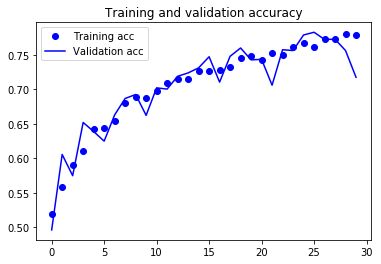

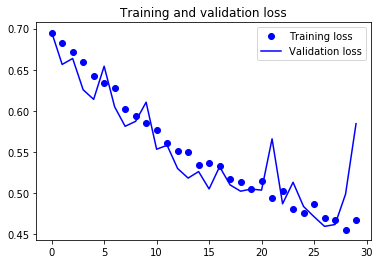

In [0]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

Our training accuracy increases linearly over time, until it reaches nearly 100%, while our 
validation accuracy stalls at 70-72%. Our validation loss reaches its minimum after only five epochs then stalls, while the training loss 
keeps decreasing linearly until it reaches nearly 0.

<font color='red'>What is the problem here? What are possible solutions? </font> </br>
<font color="blue">The problem here is the fact that the outputs are following too much the model. It means that when we have a new input which is not in the training dataset, the algorithm is underperforming : there is no generalization. We are dealing with overfitting because we don't have enough data in our dataset. To solve this issue, we need to increase the number of data. 
The graphic is not the right one because we accidently executed this cell after training the network with the data augmentation (so it's the same graph as the one at the bottom), so to reobtain the right graph we had to retrain the network without data augmentation but it would take too much time. (In the right graphic the validation results are way worse than the training results ).

## Using data augmentation

Data 
augmentation takes the approach of generating more training data from existing training samples, by "augmenting" the samples via a number 
of random transformations that yield believable-looking images. 

In Keras, this can be done by configuring a number of random transformations to be performed on the images read by our `ImageDataGenerator` 
instance.

In [0]:
datagen = ImageDataGenerator(
      rotation_range=70,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

#TODO: define the parameters

These are just a few of the options available:

* `rotation_range` is a value in degrees (0-180), a range within which to randomly rotate pictures.
* `width_shift` and `height_shift` are ranges (as a fraction of total width or height) within which to randomly translate pictures 
vertically or horizontally.
* `shear_range` is for randomly applying shearing transformations.
* `zoom_range` is for randomly zooming inside pictures.
* `horizontal_flip` is for randomly flipping half of the images horizontally -- relevant when there are no assumptions of horizontal 
asymmetry (e.g. real-world pictures).
* `fill_mode` is the strategy used for filling in newly created pixels, which can appear after a rotation or a width/height shift.

Let's take a look at our augmented images:

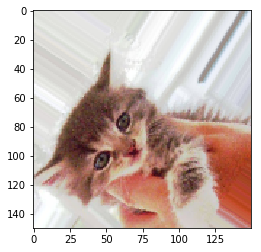

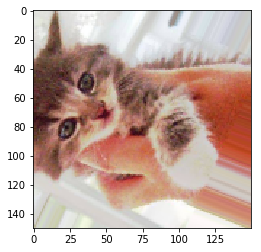

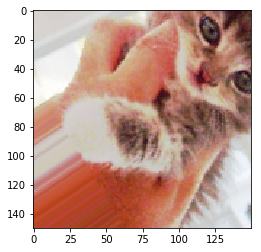

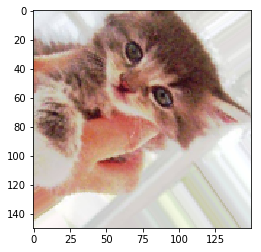

In [0]:
# This is module with image preprocessing utilities
from keras.preprocessing import image

fnames = [os.path.join(train_cats_dir, fname) for fname in os.listdir(train_cats_dir)]

# We pick one image to "augment"
img_path = fnames[3]

# Read the image and resize it
img = image.load_img(img_path, target_size=(150, 150))

# Convert it to a Numpy array with shape (150, 150, 3)
x = image.img_to_array(img)

# Reshape it to (1, 150, 150, 3)
x = x.reshape((1,) + x.shape)

# The .flow() command below generates batches of randomly transformed images.
# It will loop indefinitely, so we need to `break` the loop at some point!
i = 0
for batch in datagen.flow(x, batch_size=1):
    plt.figure(i)
    imgplot = plt.imshow(image.array_to_img(batch[0]))
    i += 1
    if i % 4 == 0:
        break

plt.show()

When using data augmentation, our network will never see twice the same input. However, the inputs 
are still heavily intercorrelated. As such, this might not be quite enough to completely get rid of overfitting. To further fight overfitting, we will also add a Dropout layer to our model, right before the densely-connected classifier:

In [0]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))

#TODO define the model
model.add(layers.Conv2D(64, (3, 3), activation='relu'))                        
model.add(layers.MaxPooling2D(pool_size=(3,3), strides=None, padding='valid')) 
model.add(layers.Conv2D(128, (5, 5), activation='relu'))                        
model.add(layers.MaxPooling2D(pool_size=(2,2), strides=None, padding='valid')) 
model.add(layers.Conv2D(128, (4, 4), activation='relu'))                       
model.add(layers.Flatten())
                             
#layers.Dropout() could be useful, please check the document of Keras.
model.add(layers.Dropout(0.5))            #pour chaque image d'entrainement, on met la moitié des neurones du réseau à 0: réduit la complexité donc permet de lutter contre l'overfitting
model.add(layers.Dense(512, activation='relu'))                               
model.add(layers.Dense(1, activation='sigmoid')) 
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

Let's train our network using data augmentation and dropout:

In [0]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size=(150, 150),
        batch_size=32,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=32,
        class_mode='binary')

history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=30,
      validation_data=validation_generator,
      validation_steps=50
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/30
100/100 [==============================] - 40s 397ms/step - loss: 0.6941 - acc: 0.5191 - val_loss: 0.6956 - val_acc: 0.4962
Epoch 2/30
100/100 [==============================] - 36s 357ms/step - loss: 0.6821 - acc: 0.5584 - val_loss: 0.6564 - val_acc: 0.6057
Epoch 3/30
100/100 [==============================] - 35s 352ms/step - loss: 0.6711 - acc: 0.5906 - val_loss: 0.6636 - val_acc: 0.5749
Epoch 4/30
100/100 [==============================] - 35s 354ms/step - loss: 0.6586 - acc: 0.6115 - val_loss: 0.6255 - val_acc: 0.6521
Epoch 5/30
100/100 [==============================] - 34s 341ms/step - loss: 0.6422 - acc: 0.6431 - val_loss: 0.6139 - val_acc: 0.6390
Epoch 6/30
100/100 [==============================] - 38s 380ms/step - loss: 0.6353 - acc: 0.6419 - val_loss: 0.6542 - val_acc: 0.6250
Epoch 7/30
100/100 [==============================] - 36s 361ms/step - loss: 0.6274 - acc: 0.6547 - val_lo

Let's save our model -- we will be using it in the section on convnet visualization.

In [0]:
model.save('cats_and_dogs_small_2.h5')

Let's plot our results again:

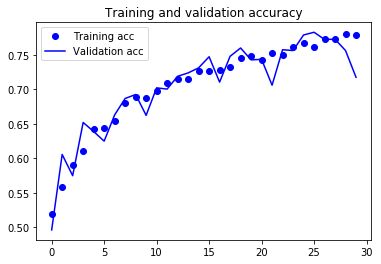

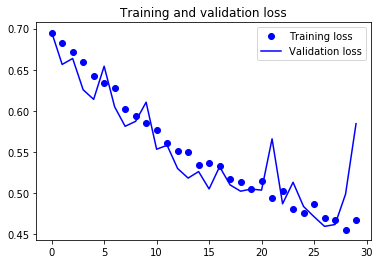

In [0]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

Thanks to data augmentation and dropout, we are no longer overfitting: the training curves are rather closely tracking the validation curves. We are now able to reach an accuracy of 81-83%, a 15% relative improvement over the non-regularized model.